In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import regex as re

In [2]:
%matplotlib inline

Given what we've learned so far, let's tackle [this Kaggle competition](https://www.kaggle.com/c/titanic-gettingStarted).

----
Read the `titanic/train.csv` and get some info on it.

In [3]:
train = pd.read_csv("titanic/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


What does our `dataFrame.head()` look like?

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


We've got many features here:

* The passenger class (first, second, or third)
* The sex of the passenger
* The age of the passenger (some are missing -- we'll have to figure out what to do about that)
* The number of siblings and spouses the passenger had on board (SubSp)
* The number of parents and children the passenger had on board (Parch)
* The amount the passenger paid for their ticket
* Where the passenger embarked from

The name and cabin are immaterial. The cabin might help, if we had a map of the ship and
there weren't so many null values for cabin.

_Using your intuition, what feature vectors might be important?_

## Finding patterns in the data

Lets make a horizontal bar chart based on the survival occurences given the sex of the passenger.

<!---
sex_results = pd.pivot_table(train, index=["Sex"], values=["Survived"])
sex_results.plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')
sex_results
-->

,Survived
Sex,
female,0.742038
male,0.188908


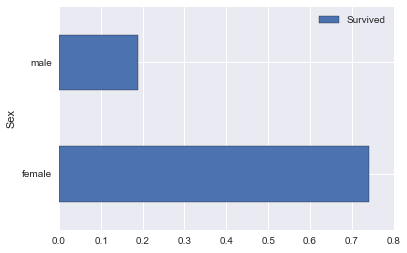

In [5]:
sex_survivor_table = pd.pivot_table(train, index=["Sex"], values=["Survived"])
sex_survivor_table.plot(kind="barh")
sex_survivor_table


There's a marked difference in survival rates between men and women. Let's go ahead and enter the competition just using that as our metric.

We need to output a CSV with the following structure:

  - PassengerId
  - Survived (as 1(Yes) or 0(No))
  
Given our assumption, lets mark Females as 1 and Males as 0.

Read in `titanic/test.csv` - otherwise your life will suck.

Write this to a CSV and upload it to the kaggle competition.

<!---
test = pd.read_csv("titanic/test.csv")
test["Survived"] = 0
test.loc[test["Sex"] == "female", "Survived"] = 1
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/gendermodel.csv", index=False)
test
-->

In [6]:
test = pd.read_csv("titanic/test.csv")
test['Survived'] = 0
test.loc[test["Sex"] == "female", "Survived"] = 1
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/gender_set.csv", index=False)


Does age seem to matter?

What do our survival rates look like when we further aggregate our sex based on their "Adult Status" (>= 18 years old)?

<!---
train["AgeRange"] = train["Age"].map(lambda x: "adult" if x >= 18 else "child")
age_plot = pd.pivot_table(train, index=["Sex", "AgeRange"], values=["Survived"])
age_plot.plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')
age_plot
--->

Survived
Sex    AgeRange          
female adult     0.771845
       child     0.690909
       unknown   0.679245
male   adult     0.177215
       child     0.396552
       unknown   0.129032

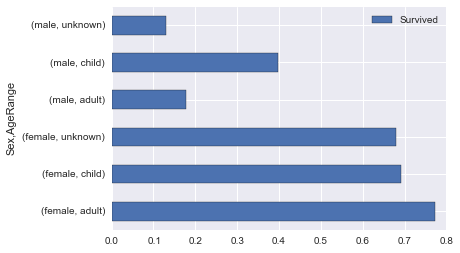

In [7]:
def create_age_range(age):
    if str(age) == "nan":
        return "unknown"
    elif age >= 18: 
        return "adult" 
    else:
        return "child"
    
train["AgeRange"] = train["Age"].map(create_age_range)


age_sex_survivor_table = pd.pivot_table(train, index=["Sex", "AgeRange"], values=["Survived"])
age_sex_survivor_table.plot(kind="barh")
age_sex_survivor_table


How about passenger class?

The `dataFrame` contains a `Pclass` column denoting the passenger class.

  - 1: First Class
  - 2: Second Class
  - 3: Third Class
  
Add the `Pclass` column to our pivot table and see how this affects our survival rates.

<!---
passenger_class = pd.pivot_table(train, index=["Sex", "Pclass"], values=["Survived"])
passenger_class.plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')
passenger_class
--->

Survived
Sex    AgeRange Pclass          
female adult    1       0.974026
                2       0.903226
                3       0.417910
       child    1       0.875000
                2       1.000000
                3       0.542857
       unknown  1       1.000000
                2       1.000000
                3       0.595238
male   adult    1       0.371134
                2       0.068182
                3       0.133333
       child    1       1.000000
                2       0.818182
                3       0.232558
       unknown  1       0.238095
                2       0.222222
                3       0.095745

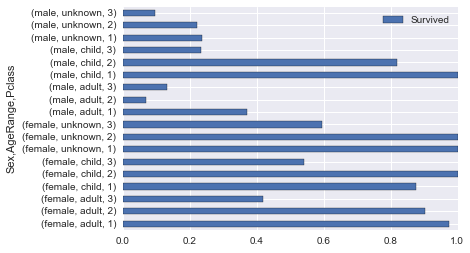

In [8]:
pclass_survivor_table = pd.pivot_table(train, index=["Sex", "AgeRange", "Pclass"], values=["Survived"])
pclass_survivor_table.plot(kind="barh")
pclass_survivor_table

Passenger class definitely mattered. The survival rate for women in 3rd class is under 50%.

What if we added in the price of the ticket? This will work best with discrete values, so we break it into tickets less than \$10, tickets between \$10 and \$20, tickets between \$20 and \$30, and tickets over \$30.

Recalculate our `TicketPrice` column to be less exact but contain price ranges.  Include our new range in our pivot table and see how this further aggregation affects our result.

<!---
def ticket_price(fare):
    if fare < 10:
        return "< $10"
    elif fare < 20:
        return "$10-20"
    elif fare < 30:
        return "$20-30"
    else:
        return "> $30"
    
train["TicketPrice"] = train["Fare"].map(ticket_price)
ticket_price = pd.pivot_table(train, index=["Sex", "Pclass", "TicketPrice"], values=["Survived"])
ticket_price.plot(kind="barh")
plt.axvline(x=0.5, linewidth=2, color='r')
ticket_price
--->

Survived
Sex    AgeRange Pclass TicketPrice          
female adult    1      $20-30       0.833333
                       > $30        0.985915
                2      $10-20       0.903226
                       $20-30       0.880000
                       > $30        1.000000

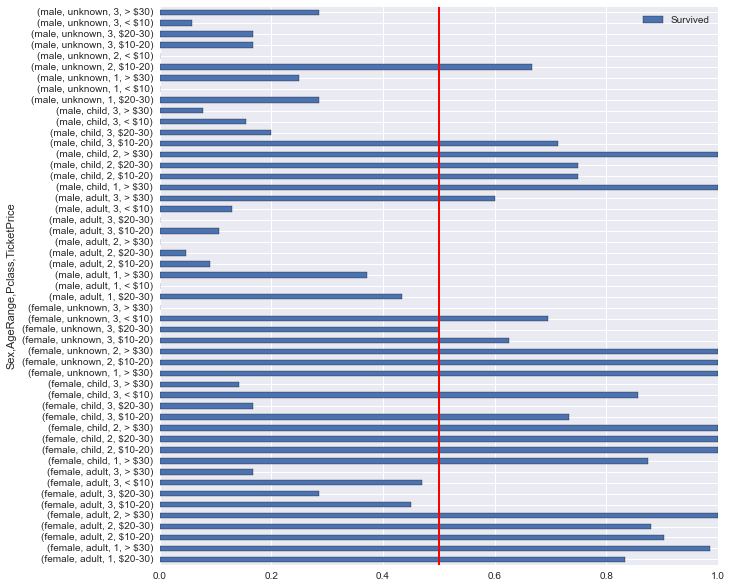

In [9]:
def ticket_price(fare):
    if fare < 10:
        return "< $10"
    elif fare < 20:
        return "$10-20"
    elif fare < 30:
        return "$20-30"
    else:
        return "> $30"
    
train["TicketPrice"] = train["Fare"].apply(ticket_price)
price_survivor_table = pd.pivot_table(train, index=["Sex", "AgeRange", "Pclass", "TicketPrice"], values=["Survived"])
price_survivor_table.plot(kind="barh", figsize=(10, 10))
plt.axvline(x=0.5, linewidth=2, color='r')
price_survivor_table.head()

Ok, this is now meaningful. The groups with survival rate > 50% are:

* Women in 1st and 2nd class.
* Women in 3rd class that paid $20 or less.

So with our new mark a passenger as Survived or not based on the above criteria.

<!---
test = pd.read_csv("titanic/test.csv")

test["Survived"] = 0
test.loc[test["Sex"] == "female", "Survived"] = 1
test.loc[(test["Pclass"] == 3) & (test["Fare"] > 20), "Survived"] = 0
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/genderclassmodel.csv", index=False)
test
--->

In [10]:
test = pd.read_csv("titanic/test.csv")
test['Survived'] = 0

test.loc[(test["Sex"] == "female"), "Survived"] = 1
test.loc[(test["Sex"] == "female") & (test["Fare"] > 20) & (test["Pclass"] == 3), "Survived"] = 0
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/gender_age_set.csv", index=False)


## Cleaning data

To do any better than this, we'll need to clean up our data. We'll need everything to be numerical so we can use them as real features.

Let's turn all the strings we might use into numbers.

<!---
train['Gender'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
--->

Get the median age of passengers by sex and class, for filling in missing ages.

Given 2 sexes and 3 classes each, calculate each median age for each category.

<!---
median_ages = np.zeros((2,3))

for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = train[(train['Gender'] == i) & \
                                 (train['Pclass'] == j+1)]['Age'].dropna().median()

median_ages
--->

In [ ]:


train['Gender'] = train['Sex'].apply(alter_gender)

In [ ]:
train.head()

In [ ]:
calc_median_ages(train[['Gender', 'Pclass', 'Age']])

Calculate the median age for each sex/class permutation as well.

Find each missing age and set it's age to the appropriate median age.

<!---
for i in range(0, 2):
    for j in range(0, 3):
        train.loc[(train.Age.isnull()) & (train.Gender == i) & (train.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

train[train['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head()
--->

In [ ]:
train = guess_ages(train)

Create a new column `AgeIsNull` and store an integer representing a Boolean as it's value.

<!---
train['AgeIsNull'] = pd.isnull(train.Age).astype(int)
--->

In [13]:
clean(train)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Embarked,AgeRange,TicketPrice,Gender,GuessedAge
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,S,adult,< $10,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,adult,> $30,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,S,adult,< $10,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,S,adult,> $30,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,S,adult,< $10,1,0
5,6,0,3,"Moran, Mr. James",25.0,0,0,8.4583,Q,unknown,< $10,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,51.8625,S,adult,> $30,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,21.0750,S,child,$20-30,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,11.1333,S,adult,$10-20,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,30.0708,C,child,> $30,0,0


In [12]:
# Helper Functions - provided for brevity

def calc_median_ages(df):
    median_ages = np.zeros((2,3))
    
    # find median age for each combination of Gender and Pclass
    
    for i in range(0, 2):
        for j in range(0, 3):
            median_ages[i,j] = df[(df['Gender'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna().median()
            
    return median_ages


def guess_ages(df, median_ages=None):
    if median_ages is None:
        median_ages = calc_median_ages(df)
    
    # Get each combination of Gender and Pclass that is null and set it's 
    # `Age` to the median age associated with it's Gender and Pclass
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[(df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                    'Age'] = median_ages[i,j]
            
    df['GuessedAge'] = pd.isnull(df.Age).astype(int)
    return df

def clean(df, median_ages=None):
    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df = guess_ages(df, median_ages)
    df = df.drop(['Ticket', 'Cabin', 'Sex'], axis=1)
    
    return df

Read in the CSV again, clean the `dataFrame` and see the `.info()` on it.

In [55]:
def alter_port(port):
        if port == "S":
            return 0
        elif port == "C":
            return 1
        else:
            return 2

train = pd.read_csv("titanic/train.csv")
train["DeparturePoint"] = train['Embarked'].apply(alter_port)
train = clean(train)
train["AgeRange"] = train['Age'].apply(create_age_range)
train["TicketPrice"] = train["Fare"].apply(ticket_price)
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Embarked,DeparturePoint,Gender,GuessedAge,AgeRange,TicketPrice
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,7.2500,S,0,1,0,adult,< $10
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,71.2833,C,1,0,0,adult,> $30
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,7.9250,S,0,0,0,adult,< $10
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,53.1000,S,0,0,0,adult,> $30
4,5,0,3,"Allen, Mr. William Henry",35,0,0,8.0500,S,0,1,0,adult,< $10


In [132]:
price_survivor_table = pd.pivot_table(train, index=["Gender", "Parch", "DeparturePoint"], values=["Survived"])
price_survivor_table


Survived
Gender Parch DeparturePoint          
0      0     0               0.729730
             1               0.895833
             2               0.828571
       1     0               0.772727
             1               0.800000
             2               0.000000
       2     0               0.564103
             1               0.888889
             2               0.000000
       3     0               0.666667
             1               1.000000
       4     0               0.000000
       5     0               0.333333
             2               0.000000
       6     0               0.000000
1      0     0               0.152815
             1               0.266667
             2               0.083333
       1     0               0.315789
             1               0.466667
             2               0.000000
       2     0               0.307692
             1               0.400000
       3     0               0.000000
       4     0               0.000000
       5     0               0.000000

We might want to get the port the passenger embarked from as a number. Do this as an exercise.

We also might want to use regular expressions on the names to look for titles like "Dr" and "Rev".

We may want to add new features, like total family size.

In [31]:
median_ages = calc_median_ages(train)
test = pd.read_csv("titanic/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [32]:
test = clean(test, median_ages)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
Gender         418 non-null int64
GuessedAge     418 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 35.9+ KB


Survived
Gender AgeRange Pclass TicketPrice          
0      adult    1      $20-30       0.833333
                       > $30        0.987500
                2      $10-20       0.906250
                       $20-30       0.880000
                       > $30        1.000000
                3      $10-20       0.500000
                       $20-30       0.400000
                       < $10        0.561404
                       > $30        0.111111
       child    1      > $30        0.875000
                2      $10-20       1.000000
                       $20-30       1.000000
                       > $30        1.000000
                3      $10-20       0.733333
                       $20-30       0.166667
                       < $10        0.857143
                       > $30        0.142857
1      adult    1      $20-30       0.400000
                       < $10        0.000000
                       > $30        0.353659
                2      $10-20       0.118644
                       $20-30       0.047619
                       < $10        0.000000
                       > $30        0.000000
                3      $10-20       0.129032
                       $20-30       0.071429
                       < $10        0.109312
                       > $30        0.416667
       child    1      > $30        1.000000
                2      $10-20       0.750000
                       $20-30       0.750000
                       > $30        1.000000
                3      $10-20       0.714286
                       $20-30       0.200000
                       < $10        0.153846
                       > $30        0.076923

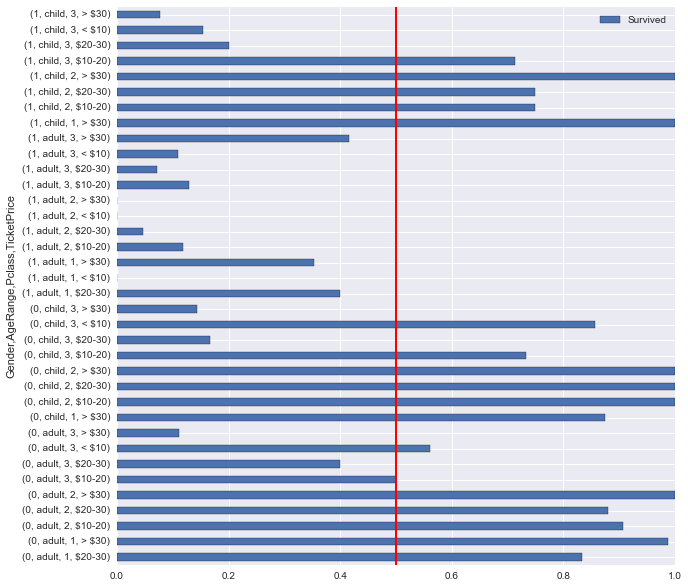

In [30]:
train["AgeRange"] = train['Age'].apply(create_age_range)
train["TicketPrice"] = train["Fare"].apply(ticket_price)
train.head()
new_price_survivor_table = pd.pivot_table(train, index=["Gender", "AgeRange", "Pclass", "TicketPrice"], values=["Survived"])
new_price_survivor_table.plot(kind="barh", figsize=(10, 10))
plt.axvline(x=0.5, linewidth=2, color='r')
new_price_survivor_table

In [27]:
test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Embarked,Gender,GuessedAge,AgeRange,TicketPrice
0,892,3,"Kelly, Mr. James",34.5,0,0,7.8292,Q,1,0,adult,< $10
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,7.0000,S,0,0,adult,< $10
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,9.6875,Q,1,0,adult,< $10
3,895,3,"Wirz, Mr. Albert",27.0,0,0,8.6625,S,1,0,adult,< $10
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,12.2875,S,0,0,adult,$10-20


In [135]:
median_ages = calc_median_ages(train)
test = pd.read_csv("titanic/test.csv")
test["AgeRange"] = test['Age'].apply(create_age_range)
test["DeparturePoint"] = test['Embarked'].apply(alter_port)

test = clean(test, median_ages)

test["Survived"] = 0
test.loc[(test["Gender"] == 0), "Survived"] = 1
test.loc[(test["Gender"] == 0) & (test["Fare"] > 20) & (test["Pclass"] == 3), "Survived"] = 0
test.loc[(test["Name"].str.match(r"\, [D].\.", re.IGNORECASE) == 1), "Survived"] = 1
test.loc[(test["Name"].str.match(r"\, [R]..\.", re.IGNORECASE) == 1), "Survived"] = 1
test.loc[(test["Gender"] == 0) & (train["Parch"] > 2) & (test["DeparturePoint"] == 2), "Survived"] = 0
test = test[["PassengerId", "Survived"]]
test.to_csv("titanic/Zach10.csv", index=False)
test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
test.head()

,PassengerId,Survived
0,892,NaN
1,893,0
2,894,NaN
3,895,NaN
4,896,0


In [ ]:
test.loc[(test["Gender"] == 0), "Survived"] = 1
test.loc[(test["Gender"] == 0) & (test["Pclass"] == 3), "Survived"] = 0
test.loc[(test['Gender'] == 1) & (test["AgeRange"] == 'child') & (test["Pclass"] == 1), "Survived"] = 1

In [105]:
#def find_dr(name):
for x in train.Name:
    y = re.findall(r"\, [D].\.", x)
    if y:
        print(x)

Minahan, Dr. William Edward
Moraweck, Dr. Ernest
Pain, Dr. Alfred
Stahelin-Maeglin, Dr. Max
Frauenthal, Dr. Henry William
Brewe, Dr. Arthur Jackson
Leader, Dr. Alice (Farnham)


In [111]:
train["Name"].str.match(r"\, [D].\.", re.IGNORECASE)


0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
861    False
862    False
863    False
864    False
865    False
866    False
867    False
868    False
869    False
870    False
871    False
872    False
873    False
874    False
875    False
876    False
877    False
878    False
879    False
880    False
881    False
882    False
883    False
884    False
885    False
886    False
887    False
888    False
889    False
890    False
Name: Name, dtype: bool

In [107]:
new_train

0      []
1      []
2      []
3      []
4      []
5      []
6      []
7      []
8      []
9      []
10     []
11     []
12     []
13     []
14     []
15     []
16     []
17     []
18     []
19     []
20     []
21     []
22     []
23     []
24     []
25     []
26     []
27     []
28     []
29     []
       ..
861    []
862    []
863    []
864    []
865    []
866    []
867    []
868    []
869    []
870    []
871    []
872    []
873    []
874    []
875    []
876    []
877    []
878    []
879    []
880    []
881    []
882    []
883    []
884    []
885    []
886    []
887    []
888    []
889    []
890    []
Name: Name, dtype: object